# Introduction
This report describes the development process of a python-based machine learning program for detecting instances of network intrusion at the application layer. The program operates on the ASNM-TUN dataset available from [1]. This work very closely follows a project specification, notable aspects of which include:

1. Development of a ML model
2. Simple visualizations
3. Optimal feature selection
4. Presentation of methods, finding, and insights

The document you are reading and most of the code it contains were created using stand-alone Jupyter Notebook [2]. It was formatted using Markdown as described in [3]. Environments like Anaconda ``navigator'' are not to this author's taste: they are too big, too commercialized, and too invasive. The Jupyter environment is convenient for developing small, experimental programs and has several convenient export options which can be extended using *pandoc* or something similiar. For the stand-alone .py file, we used a simple but powerful text editor called Sublime Text [4]. The environment used was also simple: a python virtual environment completely set up with one call each to *Python*, *pip*, *source*, and *Jupyter*, as follows:

In [201]:
# > python3 -m venv venv
# > source venv/bin/activate
# > pip install jupyter pandas scikit-learn matplotlib

Then to open Jupyter in our browser, we just call:

In [202]:
# > jupyter notebook

One of the greatest challenges this project posed was mysterious bug that caused the program run perfectly in Jupyter Notebook but failed terminate when the code was placed into a old-fashion .py file. Hours (and hours) were burned trying to discover the cause of the problem. It enventually was solved, but you will have to wait to find out how below.

The included source code file, *project2.py*, is 196 lines long including the *shebang* line and comments. Most of the challenge here was mapping details from the spec to the library documentation and wrestling some obscurity in the same. Because *Sci-kit Learn* is so huge, knowing your way around the documentation is (at least) half the battle. This project was great opportunity to explore some aspects of the library previously unvisited.

This rest of this report contains two sections: methodology, and conclusion. The code and its comments cover most of the project details. Extended comments are given where they seem helpful. The narrative is sparse by design. Most of what follows is library code from a well-documented libray called *Sci-kit Learn* [5]. There did not seem to be a need to rewrite major portions of that documentation in the name of reporting. The methodology section is structured along the same lines as the project specification following a set format of detailed requirements followed by appropriately commented code realizing those requirements. The brief conclusion gives some musings on the project and machine learning.

# Methodology
This section gives all the gory details, with the code and comments doing most of the explaining. The assumption of the author is that the reader is a reasonably-competent programmer who understands things like "instantiate the object" and "rationalizing the denominator" even though the last of these doesn't come up in what follows. The execution time of the code was variable and sometimes quite long, approaching 300 seconds. The real-world running times of programs is sort of interesting to the author so each block of our code includes a simple timing mechanism. The template for this is just below. 

In [198]:
# This is timer system:
# start = time.time()
# ...code goes here...
# end = time.time()
# print(f"Runtime: {end - start:.4f} seconds")

# We import this here so we can use it immediately below.
import time

In [184]:
# Start time for this block
start = time.time()

# Start time for total time.
# this is matched at the bottom by
# a t_end = time.time() as well as
# the subtraction problem.
t_start = time.time()

# All the required modules get imported
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import sys
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

# this is a little hack to prevent a warning later on
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

end = time.time()
print(f"Runtime: {end - start:.4f} seconds")


Runtime: 0.0006 seconds


## Data pre-processing
The list below is the first specification of project requirements. You will notice the code comments are very similar to the spec. The odd bits of text below the code blocks are program output.  

### Project requirements:
1. Load the dataset from the provided CSV file using pandas.
2. Extract candidate features (see Dataset Features section) and labels (the two-class label/three-class label) from the dataset using DataFrame[<columns>]
3. Encode labels if they are not numeric using LabelEncoder from sklearn.preprocessing.
4. Normalize the features using StandardScaler from sklearn.preprocessing.


In [185]:
start = time.time()
# Load the dataset from the provided CSV file using pandas.
try:
    df = pd.read_csv(r'CSCI589_Proj2_data.csv')
except FileNotFoundError:
    print("Dataset not found. Make sure it's in the working directory.")
    sys.exit(1)

if df.empty == False:
    print("Dataset loaded.")
    print("Please be patient, expected run-time: 45 to 300 seconds! \n")

end = time.time()
print(f"Runtime: {end - start:.4f} seconds")

Dataset loaded.
Please be patient, expected run-time: 45 to 300 seconds! 

Runtime: 0.0918 seconds


In [193]:
start = time.time()
# Extract candidate features
X = df[["SigPktLenIn","ConTcpFinCntIn","ConTcpSynCntIn",
        "InPktLen32s10i[0]","InPktLen1s10i[2]","InPktLen8s10i[7]",
        "OutPktLen1s10i[0]","FourGonAngleIn[9]","InPktLen8s10i[1]", 
        "PolyInd8ordOut[5]","PolyInd8ordIn[5]","SumTTLIn",
        "MedTTLOut","MeanTTLIn","SumPktOut", 
        "MedTCPHdrLen","SigTTLOut","SumPktLenIn",
        "SigTdiff2PktsOut","BytesPerSessOut"]]

# Extract non-numeric label_2
y = df["label_2"]

# Encode labels using LabelEncoder from sklearn.preprocessing
le = LabelEncoder() # Initialize the encoder
y = le.fit_transform(y) # Fit and transform the data

# Normalize the features using StandardScaler from sklearn.preprocessing
scaler = StandardScaler()
scaled = scaler.fit_transform(X)

end = time.time()
print(f"Runtime: {end - start:.4f} seconds")


Runtime: 0.0065 seconds


## Model training and testing
Item two of the specification below talks about training the classifier with "tuned hyperparameters." A parameter is value that gets learned from the data during training. A hyperparameter is a value outside the data that influences model training. How do we tune these? The specifics are not indicated in the spec but some reading reveals that *Sci-kit Learn* has six different hyper-parameter tuning algorithms. The one applied below is GridSearchCV which "Exhaustive search over specified parameter values for an estimator." The CV in the name stands for Cross Validation. The technical details are shown in the code below.

### Project requirements:
1. Split the dataset into training and testing sets using train_test_split from sklearn.model_selection. (80% for training, and 20% for testing)
2. Train an MLP classifier with tuned hyperparameters on the full dataset using MLPClassifier from sklearn.neural_network. (set hidden_layer_sizes=(128,32) is recommended)
3. Test the classifier and evaluate its accuracy using accuracy_score from sklearn.metrics.
4. Visualize the detection performance using confusion matrix.

In [187]:
start = time.time()
# Make train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize an MLP Classifier
mlp_full = MLPClassifier(activation='relu', 
                         alpha=0.0001, 
                         hidden_layer_sizes=(100,), 
                         learning_rate_init=0.01, 
                         solver='adam', 
                         random_state=1, 
                         verbose=False, 
                         early_stopping=True, 
                         max_iter=1000)

# Train MLP using the training data. The fit() method is what does the training.
mlp_full.fit(X_train, y_train)

end = time.time()
print(f"Runtime: {end - start:.4f} seconds")


Runtime: 0.0902 seconds


In [188]:
start = time.time()
# Tune hyperparameters: find optimal parameters using grid search 
# This is pretty amazing... but it takes a while.
parameter_grid = {
   'activation': ['identity', 'logistic', 'tanh', 'relu'],
   'alpha': [0.0001, 0.001],
   'hidden_layer_sizes': [(128,32), (100,), (50, 50)],
   'learning_rate_init': [0.001, 0.01],
   'solver': ['sgd', 'adam'],
}
grid = GridSearchCV(mlp, parameter_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters: ")
for i in grid.best_params_:
    print('    ', i)

print("\n Best cross-validation score:")
print('    ', grid.best_score_, '\n')

# The crossgrid search for optimal parameters found:
# Best parameters: {'activation': 'relu', 
#                   'alpha': 0.0001, 
#                   'hidden_layer_sizes': (100,), 
#                   'learning_rate_init': 0.01, 
#                   'solver': 'adam'}
# Best cross-validation score: 0.8634920634920634
# Note that hidden_layer_sizes difference from the suggestion in the assignment spec.

end = time.time()
print(f"Runtime: {end - start:.4f} seconds")


Best parameters: 
     activation
     alpha
     hidden_layer_sizes
     learning_rate_init
     solver

 Best cross-validation score:
     0.8634920634920634 

Runtime: 31.5962 seconds


Accuracy 1: 0.7974683544303798


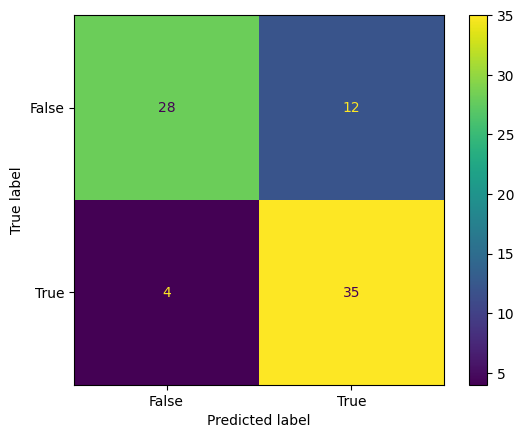

Runtime: 0.3357 seconds


In [210]:
start = time.time()

# Make predictions using the test data.
# y_pred = mlp.predict(X_test)
# Alternatively, we can use the results of the grid search:
y_pred = grid.best_estimator_.predict(X_test)

# Evaluate the model for accuracy
accuracy1 = accuracy_score(y_test, y_pred)
print(f"Accuracy 1: {accuracy1}")

# Visualize detection performance using a confusion matrix
# Ground truth, or 'y_true' is the labelled test data.
cm = confusion_matrix(y_test, y_pred, labels=mlp_full.classes_) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp2.classes_)
fig, ax = plt.subplots()

# This creates the plot
disp.plot(ax=ax)

# Saves image to current directory
# Must save before showing!
plt.savefig('output_figure_from_jupyter.png', bbox_inches='tight')

# This makes figure pop-up on the screen
plt.show()

end = time.time()
print(f"Runtime: {end - start:.4f} seconds")


## Optimal feature selection
Optimal feature selection is parameter tuning because the features are in the data. This step is caused a mysterious bug to appear. While the code ran perfectly in Jupyter, the progam would not proceed past this pointin a stand-alone .py file. It looked like an excessively long run time, and that was how I attacked it. You will notice comments in the code below metioning "optimizations." It was maddening to have code working perfectly here and not working there. This hard-to-find error prompted me to include chatGPT into my debugging process. As soon as I mentioned the code worked in Jupyter but not in the .py, the AI immediately discovered the problem and suggested a fix which worked perfectly. 

The problems was that SequentialFeatureSelector is a multi-threaded process. For reasons that are not perfectly clear, multi-threaded processes must be wrapped in a function and "protected" by an `if __name__ == "__main__":` block [6]. The final form of our working code is shown below.

In [207]:
# define a wrapper function
def main():
    # All code in 
    # the script goes
    # inside this function


if __name__ == "__main__":
    main()

Interestingly, the only mention of this requirement is found in Python's multi-processing module documentation and it is a little obscure. For multi-processing see [some details here](https://docs.python.org/3/library/multiprocessing.html). The wrapper requirement for multi-threaded code find [specific details here](https://docs.python.org/3/library/multiprocessing.html#multiprocessing-programming) [7]. Note that this is the only place this gets gets mentioned. There would have been no way I could have known the cause of this problem on my own. ChatGPT saved me hours of searching Stackoverflow for arcane answers. An AI generated summary of my interaction with chatGPT has been submitted as a separate .pdf file. By way of commentary: Now that I have used an AI in a development workflow, I will never go without it.

With the mysterious problem solved, the remaining requirements for this section of the project were fairly straight-forward. To print the selected features we used a loop with `print()` so as to not output the unsightly dictionary.

### Project requirements:
1. Leverage Forward Feature Selection (FFS) technique to select a subset of features from all the feature candidates (i.e., the features listed in the Dataset Features section). Set n_features_to_select=9 to include only 9 features in the new subset.
2. Print the selected features (Hint: see “support_” attribute in FFS documentation)

In [208]:
start = time.time()
# Using SequentialFeatureSelector from scikit-learn
# To make reduce runtime, we add two optimizations:
# 	1. reduce the value of cv from 5 to 3
#	2. add n_jobs=-1 to use all CPU cores
ffs = SequentialFeatureSelector(mlp_full, n_features_to_select=9, tol=None, direction='forward', scoring=None, cv=3, n_jobs=-1)

# fit returns self, the SFS object itself
ffs.fit(X_train, y_train)

# print selected features using get_support()
selected_mask = ffs.get_support()
selected_features = X_train.columns[selected_mask]
print("Selected features: ")
for i in selected_features:
    print('    ', i)

end = time.time()
print(f"Runtime: {end - start:.4f} seconds")


Selected features: 
     ConTcpFinCntIn
     ConTcpSynCntIn
     InPktLen8s10i[7]
     FourGonAngleIn[9]
     MedTTLOut
     MeanTTLIn
     SumPktOut
     SigTTLOut
     SigTdiff2PktsOut
Runtime: 13.5684 seconds


## Model training using the selected subset
1. Split the sub-dataset into training and testing sets. (80% - training, 20% - testing)
2. Train a new MLP classifier on the sub-dataset.
3. Test the classifier and evaluate its accuracy.
4. Visualize the detection performance using confusion matrix.

In [211]:
start = time.time()

# make the transformation
X_train_selected = ffs.transform(X_train)
X_test_selected = ffs.transform(X_test)

# train model on selected features
mlp_reduced = MLPClassifier(random_state=42, max_iter=1000)
mlp_reduced.fit(X_train_selected, y_train)

y_pred = mlp_reduced.predict(X_test_selected)

# Evaluate the model for accuracy
accuracy2 = accuracy_score(y_test, y_pred)
print(f"Accuracy 2: {accuracy2}")

# sub-time
end = time.time()
print(f"Runtime: {end - start:.4f} seconds")

# total time
t_end = time.time()
print(f"Total Runtime: {t_end - t_start:.4f} seconds")

dif = accuracy1 - accuracy2

if dif == 0:
    print(f"Difference, (accuracy1 - accuracy2): {dif}")
    print("The values of accuracy1 and accuracy2 are the same!")
else:
    print(f"Difference, (accuracy1 - accuracy2): {dif}")

Accuracy 2: 0.7974683544303798
Runtime: 0.6051 seconds
Total Runtime: 37884.4910 seconds
Difference, (accuracy1 - accuracy2): 0.0
The values of accuracy1 and accuracy2 are the same!


Note the accuracy of the model is the same whether using the full or reduced feature set. 


# Conclusion
Though our code ran fine and achieved a some result, the accuracy of 79.7468% is not very good. We used two of the optimization tools built into *Scikit-learn*: GridSearchCV and SequentialFeatureSelector. In a real-world environment, the optimal maching learning model for this application and its parameters and options would be determined by experimentation. For instance, the Random Forest classifier may perform better then the MLP. There are many options available and what works best in a given context must be discovered by the researchers in that context. Because the underlying mathematics and myriad options available, ML models are complicated and get treated as block-boxes, which is probably okay. The underlaying mathematical abstractions are hard to relate to real-world data without experimentation. 

As an opportunity for future research into ML models on network data is a systematic analysis of all the classifiers and all the optimizers available in *Scikit-learn* to get to the solid truth of what is the optimal classifier. An undertaking like this would be frought with challenges ranging the massive quantity of junk papers touching on this topic, to varitions in the network data across environments. We could go on about this, but will refrain.

As usual in courses taught by Dr. Zhang, this project was an excellent learning experience. It was a fun oportunity to set up some environments, play with the code, navigate around the documentation of a pre-eminent ML library, and struggle with some mysterious issues. It was a little dissappointing to see such a low accuracy score. Once I decided to use Jupyter Notebook for my report, the requirement for separate .py file was a little bit annoying but this isssue is multi-facted. I think an ideal balance would be along the lines of a code and write in Jupyter, export to .py for submission. If I where the instructor, I would automate the running and grading of the submitted code files and specify my assignments to easily accomodate the same.

# References
[1] I. Homoliak, “ASNM Datasets: A Collection of Network Traffic Data for Testing of Adversarial Classifiers and Network Intrusion Detectors.” IEEE, Nov. 03, 2019. Accessed: Apr. 13, 2025. [Online]. Available: <https://ieee-dataport.org/open-access/asnm-datasets-collection-network-traffic-data-testing-adversarial-classifiers-and>

[2] “Installing the classic Jupyter Notebook interface — Jupyter Documentation 4.1.1 alpha documentation.” Accessed: Apr. 13, 2025. [Online]. Available: <https://docs.jupyter.org/en/latest/install/notebook-classic.html#alternative-for-experienced-python-users-installing-jupyter-with-pip>

[3] “Basic Syntax | Markdown Guide.” Accessed: Apr. 13, 2025. [Online]. Available: <https://www.markdownguide.org/basic-syntax/>

[4] “Sublime Text - the sophisticated text editor for code, markup and prose.” Accessed: Apr. 13, 2025. [Online]. Available: <https://www.sublimetext.com/>

[5] “scikit-learn: machine learning in Python — scikit-learn 1.6.1 documentation.” Accessed: Apr. 13, 2025. [Online]. Available: <https://scikit-learn.org/stable/index.html>

[6] “ChatGPT.” Accessed: Apr. 13, 2025. [Online]. Available: <https://chatgpt.com>

[7] “multiprocessing — Process-based parallelism,” Python documentation. Accessed: Apr. 13, 2025. [Online]. Available: <https://docs.python.org/3/library/multiprocessing.html>
